In [3]:
# 1. Merging Data => Combining addatas, leiden clustering
# 2. Groups
# 2.1 Apply TCR on RNA clusters
# 2.2 Apply RNA on TCR clusters
# 3. Multimodal integration
# 3.1. TCR
# 3.1.1 TESSA
# 3.1.2 CONGA
# 3.1.3 mvTCR
# 3.2. BCR
# 3.2.1. new TESSA
# 4. Take Home messages
# 5. Quiz

# Introduction

With the development of novel single cell technology, IR sequencing is combined often with other Omic-layers, especially with transcriptomics. For B- and T-cells this enables the analysis of various characteristics on a single cell level: while the transcriptome provides insights into the current state of the cell, the IR is indicative for the cell's specificity and thereby explains the cell's fate upon infection or vaccination. 

# Data Preparation

In [6]:
import warnings

warnings.filterwarnings(
    "ignore",
    ".*IProgress not found*",
)
warnings.simplefilter(action="ignore", category=FutureWarning)

import scanpy as sc
import scirpy as ir
import pandas as pd
import numpy as np
import seaborn as sb

In [ ]:
path_gex_tcr = f"{path_data}/E-MTAB-10026.processed.4/covid_portal_210320_with_raw.h5ad"
path_gex_bcr = f"{path_data}/E-MTAB-10026.processed.4/covid_portal_210320_with_raw.h5ad"
path_tcr = f"{path_data}/TCR_01_preprocessed_tcr.h5ad"
path_bcr = f"{path_data}/BCR_01_preprocessed_tcr.h5ad"

First we will load the Gene expression data processed by the authors. You can download the full dataset from https://www.ebi.ac.uk/arrayexpress/files/E-MTAB-10026/E-MTAB-10026.processed.4.zip . Since we are working only with the B- and T-cells of selected donors, we provide a downsampled dataset for you:

In [ ]:
! wget -O $path_bcr_input -nc https://figshare.com/ndownloader/files/35574338

Let's load the GEX and the previously annotated TCR data. Both AnnData objects can then easily be merged via scirpy into a shared AnnData object, which will store IR information in adata.obs and GEX in adata.X.

In [17]:
adata_tc = sc.read(path_gex_tcr)
adata_tcr = sc.read(path_tcr)

ir.pp.merge_with_ir(adata_tc, adata_tcr)

In [19]:
# todo offline remove non TCRs and non BCRs

In [21]:
# remove once fixed
adata = adata[adata.obs["patient_id_x"] == "AP6"]
print("Amount of cells: ", len(adata))

Amount of cells:  4350


To get an overview, we will plot the data with cluster assigment as a UMAP visualisation.

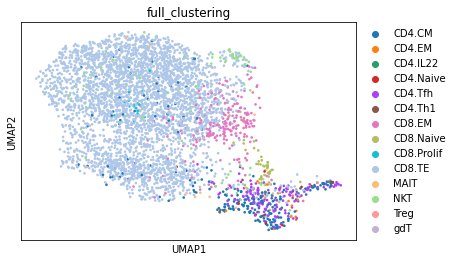

In [147]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="full_clustering")

Similar, we merge with the BCR and GEX data for B cells.

In [18]:
adata_bc = sc.read(path_gex_bcr)
adata_bcr = sc.read(path_bcr)

ir.pp.merge_with_ir(adata_bc, adata_bcr)

In [ ]:
# downsample

In [ ]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color="full_clustering")

# Uni-modal Analysis with Cross-modal conditions

While studies often provide paired measurements for both modalities, these are often analyzed individually utilizing only limited shared information. Often one modality (VDJ or transcriptome) is used to provide conditions, on which the other modality is then analyzed. E.g. we can observe how cells from the same clonal lineage adapt to study design by DEG analysis of these cells in different points in time. 

Previously, we covered these unimodal analysis in other sections of this book. Here, we will focus, on how we can apply these techniques across VDJ and other modalities, rather than explaining the underlying approaches. To find a more detailed explanation please refer to the corresponding chapters.

## AIR analysis on RNA clusters

We have shown sequence and diversity analysis of AIRs in chapter (LINK UNIMODAL SEQUENCE ANALYSIS). When paired VDJ- and transcriptome data is available, we can perform similar analysis on cell clusters defined in the RNA-space. How these RNA-clusters are defined, is depending on the study design. Selected ways to define RNA clusters for AIR analysis:

- **Leiden Clusters**: Arguably the easiest way to define subsets of cells within count data, is via clustering algorithms. Usually, leiden clustering is performed and highly expressed genes of the clusters are used to determine the cells' state. We can now conduct the TCR analysis on clusters of interest (e.g. an activated cluster that is likely disease-specific). 
- **Marker Genes**: We can select AIR cells based on specific marker genes, that are indicative for specific cell states. Depending on your research questions, you should select your marker genes accordingly (e.g. markers for proliferation, activation, suppression).
- **Cell Types**: Several subcelltypes exist for B- and T-Cells for various degrees of hierachy. After these celltypes are annotated via transcriptome or other modalities, we can investigate how the repertoire composition differs among this label. This analysis can either be performed within sample (how does the repertoire differ between celltypes) or within a celltype across samples (e.g. how does the repertoire of CD8 effector T-cells change between disease and healthy patients).

## GEX analysis on AIR clusters
Similarly, we can perform the standard analysis of transcriptome (LINK UNIMODAL GEX ANALYSIS), but on groups derived in the AIR space:

- **Clonotype**: AIR clonotypes can be used as clusters, if sufficient clonal expansion is present. This is especially intruiging, since the clonotype serves as a proxy for the cells specificity. Cells recognizing the same antigen can therefore be tracked over conditions such as time, treatment, or stimulation, to observe their change in 
- **Clonotype Network**:
- **Disease Specific**:



# Multimodal Integration
In the previous chapter we have shown, how modality specific analysis is performed on clusters derived from other modalities. However, this underutilizes the additional information provided by paired data, since AIRs and gene expression have been shown to be interlinked: adaptive immune cells recognizing the same epitopes, will undergo a similar development upon activation. Therefore, it has been shown that adaptive immune cells with similar IR, expressed a similar phenotype. As for other omics-combination, there has been an interest lately in integrating AIR and GEX for deriving clusters or a shared representation. These models are still very novel and are not part of most established analysis pipelines. We assume that these or similar approaches will be increasingly used in the future and therefore want to showcase these integration models. However, you should still be careful when applying these models, since they are still experimental and not independently evaluated for their strengths and weaknesses.

## TCR
Only recently, three methods were developed to jointly utilize TCR sequences and transcriptome each aiming at different aspects of analysis: 
- **TESSA**: applies a Bayesian model on a TCR and GEX embedding for clustering T cells of similar transcriptome and sequences.
- **Conga**: clusters T cell clones through a graph-theoretic approach by distances of GEX and TCR
- **mvTCR**: uses Deep Variational Autoencoders to derive a shared embedding of GEX and TCR.

### TESSA
... et al developed TCR functionallandscape estimation supervised with scRNA-seq analysis (TESSA), which aims at embedding and clustering T cell clones based on their TCR sequence and transcriptome via Bayesian modelling. The CDR3beta sequence is first compressed to a 30-dimensional numeric representation using a (pretrained?, Variational?) Autoencoder. Following, the dimensions are upweighted to correlate the TCR representation with the gene expression of similar TCR-groups, thereby assigning importance of TCR position? for explaining the cells gene expression. In an interative process, weights and groups are updated until convergence to reach a maximal allignment between both modalities.

TESSA produced clusters of high purity when embedding Tcells with known epitope specificity from [10x], surpasing the uni-modal model GLIPH [], which is commonly used for clustering TCR sequences. Further, cluster centrally was indicative for higher avidity clones shown by clonal expansion and high ADT counts. Using TESSA on data from [Yost], the author detected novel clusters of responder T cell in patients undergoing PD-1 blockade. 

https://github.com/jcao89757/TESSA

TESSA requires several TCR and GEX files in specific format.

First, we save a ".csv"-File with the the following columns:
- **contig_id**: cell barcodes as index column
- **cdr3**: CDR3beta amino acid sequence trimmed for starting C and ending F

In [49]:
df_tcr = adata.obs
df_tcr.index.name = "contig_id"
df_tcr["cdr3"] = [
    seq[1:-1] for seq in df_tcr["IR_VDJ_1_junction_aa"]
]  # trimm cdr3 sequence

df_tcr = df_tcr[["cdr3"]]  # select only columns needed

df_tcr.to_csv(f"{path_tmp}/TESSA_tcrs.csv")
df_tcr.head(5)

cdr3
contig_id                             
S11_AAACCTGGTAATTGGA-1    ASSPGTGTYGYT
S11_AAACCTGGTAGCACGA-1    ASSIPGAVHEQY
S11_AAACCTGTCGCCGTGA-1  ASSPQTGVARYGYT
S11_AAACCTGTCTTATCTG-1       ASLGNTEAF
S11_AAACGGGGTAGCGATG-1   ASSGGGSSYNEQF

We will filter the 10% most variable genes, as done in the TESSA publication.

In [11]:
n_genes = adata.shape[1] // 10
sc.pp.highly_variable_genes(adata, n_top_genes=n_genes)
adata_tessa = adata[:, adata.var["highly_variable"]].copy()

We now store the GEX matrix to a ".csv"-File. TESSA requires the transposed matrix of the adata object. I.e. the rows represent the different genes and the columns indicate a specific cell. For this, we will store the count data in a DataFrame with the right index and column names. Following, we transpose the DataFrame.

In [12]:
count_mat = adata_tessa.X.A
df_counts = pd.DataFrame(count_mat)

df_counts.index = adata_tessa.obs.index
df_counts.index.name = ""
df_counts.columns = adata_tessa.var.index

df_counts = df_counts.transpose()

df_counts.to_csv(f"{path_tmp}/TESSA_gex.csv")
df_counts.head()

S11_AAACCTGGTAATTGGA-1  S11_AAACCTGGTAGCACGA-1  \
HES4                         0.0                 0.00000   
ISG15                        0.0                 1.54457   
TTLL10                       0.0                 0.00000   
TNFRSF18                     0.0                 0.00000   
TNFRSF4                      0.0                 0.00000   

          S11_AAACCTGTCGCCGTGA-1  S11_AAACCTGTCTTATCTG-1  \
HES4                    0.000000                  0.0000   
ISG15                   2.430966                  0.9284   
TTLL10                  0.000000                  0.0000   
TNFRSF18                0.000000                  0.0000   
TNFRSF4                 0.000000                  0.9284   

          S11_AAACGGGGTAGCGATG-1  S11_AAACGGGGTCGGCACT-1  \
HES4                         0.0                 0.00000   
ISG15                        0.0                 1.64661   
TTLL10                       0.0                 0.00000   
TNFRSF18                     0.0                 0.00000   
TNFRSF4                      0.0                 0.00000   

          S11_AAACGGGGTTACGGAG-1  S11_AAAGCAAAGAGCAATT-1  \
HES4                    0.000000                0.000000   
ISG15                   1.565189                4.062155   
TTLL10                  0.000000                0.000000   
TNFRSF18                0.000000                0.000000   
TNFRSF4                 0.000000                0.000000   

          S11_AAAGCAAAGCAGGTCA-1  S11_AAAGCAAAGGCAGGTT-1  ...  \
HES4                     0.00000                0.000000  ...   
ISG15                    1.53851                2.475721  ...   
TTLL10                   0.00000                0.000000  ...   
TNFRSF18                 0.00000                0.000000  ...   
TNFRSF4                  0.00000                0.000000  ...   

          S12_TTTGGTTGTACATCCA-1  S12_TTTGGTTGTAGGACAC-1  \
HES4                    0.000000                0.000000   
ISG15                   1.884326                1.988038   
TTLL10                  0.000000                0.000000   
TNFRSF18                0.000000                0.000000   
TNFRSF4                 0.000000                0.000000   

          S12_TTTGGTTTCAAGAAGT-1  S12_TTTGGTTTCTACTATC-1  \
HES4                         0.0                0.000000   
ISG15                        0.0                1.581859   
TTLL10                       0.0                0.000000   
TNFRSF18                     0.0                0.000000   
TNFRSF4                      0.0                0.000000   

          S12_TTTGGTTTCTCGCTTG-1  S12_TTTGTCACACGGTAGA-1  \
HES4                    0.000000                     0.0   
ISG15                   1.511785                     0.0   
TTLL10                  0.000000                     0.0   
TNFRSF18                0.000000                     0.0   
TNFRSF4                 0.000000                     0.0   

          S12_TTTGTCAGTAGAAAGG-1  S12_TTTGTCAGTGAGTGAC-1  \
HES4                    0.000000                0.000000   
ISG15                   2.015501                2.088418   
TTLL10                  0.000000                0.000000   
TNFRSF18                0.000000                0.000000   
TNFRSF4                 0.000000                0.000000   

          S12_TTTGTCATCCACTCCA-1  S12_TTTGTCATCGCATGAT-1  
HES4                    0.000000                     0.0  
ISG15                   1.611682                     0.0  
TTLL10                  0.000000                     0.0  
TNFRSF18                0.000000                     0.0  
TNFRSF4                 0.000000                     0.0  

[5 rows x 4350 columns]

To run the model, we will need to provide different setting options, most of which specify input or output directories. We will summarize them in a dictionary first.

In [22]:
settings_full = {
    # Input files
    "tcr": f"{path_tmp}/TESSA_tcrs.csv",
    "exp": f"{path_tmp}/TESSA_gex.csv",
    # TESSA models
    "model": f"TESSA/BriseisEncoder/TrainedEncoder.h5",
    "embeding_vectors": f"TESSA/BriseisEncoder/Atchley_factors.csv",
    # Output files
    "output_TCR": f"{path_res}/TESSA_tcr_embedding.csv",
    "output_log": f"{path_res}/TESSA_log.log",
    "output_tessa": f"{path_res}",
    "within_sample_networks": "FALSE",
}

In the next step, we will create the command for running TESSA by adding setting key and setting option.

In [26]:
command_full = "conda activate TESSA && "

command_full += "python TESSA/Tessa_main.py"
for key, value in settings_full.items():
    command_full += f" -{key} {value}"
command_full

'conda activate TESSA && python TESSA/Tessa_main.py -tcr tmp/TESSA_tcrs.csv -exp tmp/TESSA_gex.csv -model TESSA/BriseisEncoder/TrainedEncoder.h5 -embeding_vectors TESSA/BriseisEncoder/Atchley_factors.csv -output_TCR res/TESSA_tcr_embedding.csv -output_log res/TESSA_log.log -output_tessa res -within_sample_networks FALSE'

Finally, we run the model on the specified settings by calling the command. Depending on your compute ressources this might take several minutes.

In [27]:
!$command_full

2022-04-20 15:12:02.778163: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX AVX2
Using TensorFlow backend.
C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 


Initialization
[1] 123

Iteration round: 1 
  # clusters: 679 
  Clustering rate: 0 
  Recent b acceptance rate: 0 

Iteration round: 2 
  # clusters: 163 
  Clustering rate: 0.918 
  Recent b acceptance rate: 0 

Iteration round: 3 
  # clusters: 117 
  Clustering rate: 0.997 
  Recent b acceptance rate: 0 

Iteration round: 4 
  # clusters: 116 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 5 
  # clusters: 117 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 6 
  # clusters: 118 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 7 
  # clusters: 117 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 8 
  # clusters: 117 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 9 
  # clusters: 117 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 10 
  # clusters: 117 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 11 
  # clu

C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint16 = np.dtype([("quint16", np.uint16, 1)])
C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint32 = np.dtype([("qint32", np.int32, 1)])
C:\Users\felix.drost\Anaconda3\envs\TESSA\lib\site-packages\tensorflow\python\framework\dtypes.py:532: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  np_resource = np.dtype([("resource", np.ubyte, 1)])
sys:1: FutureWarning: arrays to stack must be 


Iteration round: 24 
  # clusters: 118 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 25 
  # clusters: 118 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 26 
  # clusters: 119 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 27 
  # clusters: 119 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 28 
  # clusters: 119 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 29 
  # clusters: 120 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 30 
  # clusters: 120 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 31 
  # clusters: 120 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 32 
  # clusters: 119 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 33 
  # clusters: 119 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 34 
  # clusters: 119 
  C

Iteration round: 600 
  # clusters: 126 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 601 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 602 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 603 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 604 
  # clusters: 126 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 605 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 606 
  # clusters: 126 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 607 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 608 
  # clusters: 126 
  Clustering rate: 0.999 
  Recent b acceptance rate: 0 

Iteration round: 609 
  # clusters: 125 
  Clustering rate: 1 
  Recent b acceptance rate: 0 

Iteration round: 610 
  # clusters

We now recieve two output files, that we can further use for downstream tasks:
- TESSA_tcr_embedding.csv: Embedding of TCRs (without GEX information)
- result_meta.csv: cluster assignment by cell
- tessa_final.RData: Containing inferred model parameters (e.g. weightening vector b)

To analyse the TESSA output, load the TCR embedding. We will create an adata object for easier data handling:

In [109]:
tessa_embedding = pd.read_csv(f"{path_res}/TESSA_tcr_embedding.csv", index_col=0)
tessa_embedding = sc.AnnData(X=tessa_embedding.values, obs=adata.obs)

We can now apply various analysis steps on this embedding such as visualization. Let's plot a TSNE plot colored by celltype.

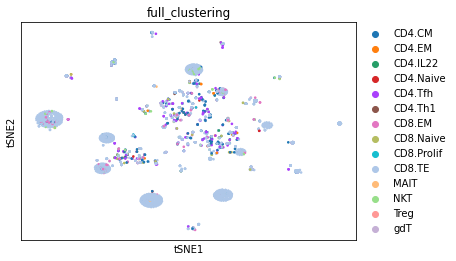

In [152]:
sc.pp.neighbors(tessa_embedding)
sc.tl.tsne(tessa_embedding)
sc.pl.tsne(tessa_embedding, color="full_clustering")

As a next step, we will load the cluster assignments created by TESSA saved in 'result_meta.csv' and add it to the adata object. Each cluster is named after one clonotype CDR3beta region within this cluster 

In [156]:
clustering = pd.read_csv(f"{path_res}/result_meta.csv", index_col=0)
tessa_embedding.obs["TESSA_cluster"] = clustering["cluster_number"].values
print("Unique clusters:", tessa_embedding.obs["TESSA_cluster"].nunique())

Unique clusters: 125


There are 125 unique clusters. For visualization, we will plot only the 10 most abundent clusters within the adata object to a TSNE plot.

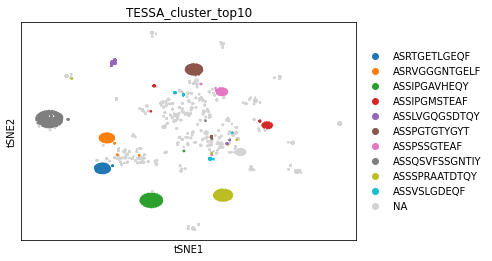

In [153]:
top_10_clusters = tessa_embedding.obs["TESSA_cluster"].value_counts().head(10).index
tessa_embedding.obs["TESSA_cluster_top10"] = tessa_embedding.obs["TESSA_cluster"].apply(
    lambda x: x if x in top_10_clusters else np.nan
)

sc.pl.tsne(tessa_embedding, color="TESSA_cluster_top10")

For plotting the cluster assignemnt in the GEX space, we add the assignment to the original adata object. When plotting, we can see that TESSA clusters also share similar phenotypes at GEX level.

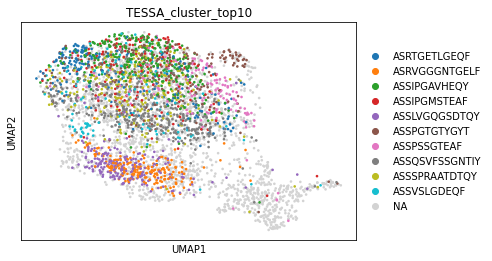

In [149]:
adata.obs["TESSA_cluster_top10"] = tessa_embedding.obs["TESSA_cluster_top10"]
sc.pl.umap(adata, color="TESSA_cluster_top10")

TESSA offers additional visualization of clonotype networks. To access this, we will use the provided R scripts.

We first need to set the path to our R environment, you might need to adjust the path, based on the location of your python environment before importing the rpy2 interface between python and R.

In [37]:
# Create path to standard Anaconda location
home = os.path.expanduser("~")
os.environ["R_HOME"] = f"{home}/Anaconda3/envs/best_practice/Lib/R"
os.environ["R_LIBS"] = f"{home}/Anaconda3/envs/best_practice/Lib/R/lib"

import rpy2.robjects as rob

%load_ext rpy2.ipython

We use jupyter notebooks linemagic to load the TESSA results and visualization code. Following, we call the two visualization functions. They will output PDF plots to the results directory.

In [49]:
%%R -i path_res
load('res/tessa_final.RData')
source('TESSA/Tessa/post_analysis.R')
plot_Tessa_clusters(tessa_results, path_res)
plot_tessa(tessa_results, path_res)

This plot provides us with a visulisation of the clonotype netwoorks. The dot size here represents the clonal expansion of the individual clone.

In [55]:
from IPython.display import IFrame

IFrame("res/TCR_explore_clusters.pdf", width=600, height=300)

There are several other plots, that can be found in the output folder. As an example, here you can see the dependency between TCR distance and GEX distance within each clonotype cluster.

In [52]:
IFrame("res/exp_TCR_pair_plot.pdf", width=600, height=300)

# CoNGA
clonotype neighbor graph analysis (CoNGA) uses similarity graphs at a clonotype level on GEX and TCR, for which the well known distance metric TCRDist [] is used. Based on the graph neighborhood, clusters are formed by shared GEX and TCR assignments. These so called "CoNGA clusters" thereby share similar receptor sequences as well as similar gene expression. 

CoNGA clusters contained clonotypes with highly alike TCRs based on e.g. length and physio-chemical properties and were shown to capture specificity well on []. Among other things, CoNGA was used to identified clusters of mhc-indepent HOBIT/HELIOS-type T-cells in data from []. 

Note, that CoNGA offers support to BCR sequences as stated on their GitHub Page. However, this was not part of the evaluation in the original publication.

The following explanation is a compressed version of the authors explanation at https://github.com/phbradley/conga/blob/master/colab_conga_pipeline.ipynb

## Installation

In [158]:
!pip install cairosvg

  Created wheel for cairocffi: filename=cairocffi-1.3.0-py3-none-any.whl size=89683 sha256=4fa8f0076447dfe0b40422207475bd1b2c3b162f0914c75ea21a7c4cd9dfffd7
  Stored in directory: c:\users\felix.drost\appdata\local\pip\cache\wheels\4e\ca\e1\5c8a9692a27f639a07c949044bec943f26c81cd53d3805319f
Successfully built cairocffi


In [159]:
!git clone https://github.com/phbradley/conga.git

Cloning into 'conga'...
Updating files:  93% (122/131)
Updating files:  94% (124/131)
Updating files:  95% (125/131)
Updating files:  96% (126/131)
Updating files:  97% (128/131)
Updating files:  98% (129/131)
Updating files:  99% (130/131)
Updating files: 100% (131/131)
Updating files: 100% (131/131), done.


In [9]:
! cd conga//tcrdist_cpp// && make
g++ -O3 -std=c++11 -Wall -I ./include/ -o ./bin/find_neighbors ./src/find_neighbors.cc

In file included from ./include/tclap/Arg.h:55,
                 from ./include/tclap/SwitchArg.h:30,
                 from ./include/tclap/CmdLine.h:27,
                 from ./src/misc.hh:12,
                 from ./src/tcrdist.hh:7,
                 from ./src/find_neighbors.cc:2:
./include/tclap/ArgTraits.h: In instantiation of 'struct TCLAP::ArgTraits<long long unsigned int>':
./include/tclap/ValueArg.h:403:51:   required from 'void TCLAP::ValueArg<T>::_extractValue(const string&) [with T = long long unsigned int; std::string = std::__cxx11::basic_string<char>]'
./include/tclap/ValueArg.h:363:5:   required from 'bool TCLAP::ValueArg<T>::processArg(int*, std::vector<std::__cxx11::basic_string<char> >&) [with T = long long unsigned int]'
./include/tclap/ValueArg.h:328:6:   required from here
./include/tclap/ArgTraits.h:80:39: error: 'long long unsigned int' is not a class, struct, or union type
   80 |     typedef typename T::ValueCategory ValueCategory;
      |                     

In [165]:
! cd conga// && pip install -e .

Obtaining file:///C:/Daten/Projects/BestPractice2.0/notebooks/multimodal_vdj/conga
  Running setup.py develop for conga


## Data Preperation

In [22]:
path_reduced_joint = f"{path_data}/joint_data_reduced.h5ad"
sc.write(adata=adata, filename=path_reduced_joint)

In [23]:
df_tcr = pd.read_csv(
    f"{path_data}/E-MTAB-10026.processed.2/TCR_merged-Updated.tsv",
    sep="\t",
    index_col=0,
)
df_tcr = df_tcr.loc[adata.obs.index]

path_reduced_tcr = f"{path_data}/tcr_reduced.h5ad"
df_tcr.to_csv(path_reduced_tcr)

C:\Users\felix.drost\Anaconda3\envs\best_practice\lib\site-packages\IPython\core\interactiveshell.py:3186: DtypeWarning: Columns (38,39,40) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
import conga

organism = "human"

path_clones = f"{path_tmp}/cogna_clones.tsv"
outfile_prefix = "conga"

In [29]:
conga.tcrdist.make_10x_clones_file.make_10x_clones_file(
    path_reduced_tcr, organism, path_clones
)
conga.preprocess.make_tcrdist_kernel_pcs_file_from_clones_file(path_clones, organism)

repeat?? 2 222 ('TRBV18*01', 'TRBJ1-4*01', 'CASSIGGQIYEKLFF', 'tgtgccagtagtattggagggcagatatatgaaaaactgtttttt') ('TRBV19*01', 'TRBJ1-4*01', 'CASSIGGQIYEKLFF', 'tgtgccagtagtattggagggcagatatatgaaaaactgtttttt')
repeat?? 2 88 ('TRAV18*01', 'TRAJ40*01', 'CALSPQTPGTYKYIF', 'tgtgctctgagtccccaaaccccaggaacctacaaatacatcttt') ('TRAV19*01', 'TRAJ40*01', 'CALSPQTPGTYKYIF', 'tgtgctctgagtccccaaaccccaggaacctacaaatacatcttt')
repeat?? 472 11 ('TRBV11-2*01', 'TRBJ2-1*01', 'CASSLDLLLRYNEQFF', 'tgtgccagcagcttagatctactactaagatacaatgagcagttcttc') ('TRBV7-2*01', 'TRBJ2-1*01', 'CASSLDLLLRYNEQFF', 'tgtgccagcagcttagatctactactaagatacaatgagcagttcttc')
ab_counts: [((1, 1), 2107), ((2, 2), 1834), ((2, 1), 112), ((3, 2), 103), ((2, 3), 99), ((3, 3), 64), ((4, 2), 14), ((1, 2), 9)]
old_unpaired_barcodes: 0 old_paired_barcodes: 4350 new_stringent_paired_barcodes: 2219
compute tcrdist distance matrix for 629 clonotypes
Using Python TCRdist calculator. Consider compiling C++ calculator for faster perfomance.
running Kerne

In [35]:
df_tcr

Centre             barcode  is_cell  \
CellID                                                        
S11_AAACCTGGTAATTGGA-1  Sanger  AAACCTGGTAATTGGA-1     True   
S11_AAACCTGGTAATTGGA-1  Sanger  AAACCTGGTAATTGGA-1     True   
S11_AAACCTGGTAGCACGA-1  Sanger  AAACCTGGTAGCACGA-1     True   
S11_AAACCTGGTAGCACGA-1  Sanger  AAACCTGGTAGCACGA-1     True   
S11_AAACCTGTCGCCGTGA-1  Sanger  AAACCTGTCGCCGTGA-1     True   
...                        ...                 ...      ...   
S12_TTTGTCAGTGAGTGAC-1  Sanger  TTTGTCAGTGAGTGAC-1     True   
S12_TTTGTCATCCACTCCA-1  Sanger  TTTGTCATCCACTCCA-1     True   
S12_TTTGTCATCCACTCCA-1  Sanger  TTTGTCATCCACTCCA-1     True   
S12_TTTGTCATCGCATGAT-1  Sanger  TTTGTCATCGCATGAT-1     True   
S12_TTTGTCATCGCATGAT-1  Sanger  TTTGTCATCGCATGAT-1     True   

                                          contig_id  high_confidence  length  \
CellID                                                                         
S11_AAACCTGGTAATTGGA-1  AAACCTGGTAATTGGA-1_contig_2             True     677   
S11_AAACCTGGTAATTGGA-1  AAACCTGGTAATTGGA-1_contig_1             True     473   
S11_AAACCTGGTAGCACGA-1  AAACCTGGTAGCACGA-1_contig_1             True     657   
S11_AAACCTGGTAGCACGA-1  AAACCTGGTAGCACGA-1_contig_2             True     551   
S11_AAACCTGTCGCCGTGA-1  AAACCTGTCGCCGTGA-1_contig_2             True     475   
...                                             ...              ...     ...   
S12_TTTGTCAGTGAGTGAC-1  TTTGTCAGTGAGTGAC-1_contig_1             True     521   
S12_TTTGTCATCCACTCCA-1  TTTGTCATCCACTCCA-1_contig_2             True     561   
S12_TTTGTCATCCACTCCA-1  TTTGTCATCCACTCCA-1_contig_1             True     634   
S12_TTTGTCATCGCATGAT-1  TTTGTCATCGCATGAT-1_contig_2             True     670   
S12_TTTGTCATCGCATGAT-1  TTTGTCATCGCATGAT-1_contig_1             True     510   

                       chain    v_gene d_gene   j_gene  ... Days_from_onset  \
CellID                                                  ...                   
S11_AAACCTGGTAATTGGA-1   TRA  TRAV12-1   None    TRAJ9  ...              17   
S11_AAACCTGGTAATTGGA-1   TRB  TRBV10-2   None  TRBJ1-2  ...              17   
S11_AAACCTGGTAGCACGA-1   TRB    TRBV19   None  TRBJ2-7  ...              17   
S11_AAACCTGGTAGCACGA-1   TRA  TRAV26-2   None   TRAJ53  ...              17   
S11_AAACCTGTCGCCGTGA-1   TRA    TRAV24   None   TRAJ49  ...              17   
...                      ...       ...    ...      ...  ...             ...   
S12_TTTGTCAGTGAGTGAC-1   TRB   TRBV6-5   None  TRBJ1-2  ...              17   
S12_TTTGTCATCCACTCCA-1   TRB   TRBV5-6   None  TRBJ2-7  ...              17   
S12_TTTGTCATCCACTCCA-1   TRA   TRAV8-6   None   TRAJ57  ...              17   
S12_TTTGTCATCGCATGAT-1   TRA   TRAV8-2   None   TRAJ22  ...              17   
S12_TTTGTCATCGCATGAT-1   TRB    TRBV14   None  TRBJ2-5  ...              17   

                        time_after_LPS  Worst_Clinical_Status  Outcome leiden  \
CellID                                                                          
S11_AAACCTGGTAATTGGA-1             NaN                    NaN  unknown      2   
S11_AAACCTGGTAATTGGA-1             NaN                    NaN  unknown      2   
S11_AAACCTGGTAGCACGA-1             NaN                    NaN  unknown      2   
S11_AAACCTGGTAGCACGA-1             NaN                    NaN  unknown      2   
S11_AAACCTGTCGCCGTGA-1             NaN                    NaN  unknown     26   
...                                ...                    ...      ...    ...   
S12_TTTGTCAGTGAGTGAC-1             NaN                    NaN  unknown     19   
S12_TTTGTCATCCACTCCA-1             NaN                    NaN  unknown     26   
S12_TTTGTCATCCACTCCA-1             NaN                    NaN  unknown     26   
S12_TTTGTCATCGCATGAT-1             NaN                    NaN  unknown     10   
S12_TTTGTCATCGCATGAT-1             NaN                    NaN  unknown     10   

                        consensus  initial_clustering study_id  AgeRange Age  
Ce

In [36]:
adata.obs

sample_id  n_genes  n_genes_by_counts  total_counts  \
covid_index                                                                  
S11_AAACCTGGTAATTGGA-1       AP6     1763               1763        3950.0   
S11_AAACCTGGTAGCACGA-1       AP6     1400               1400        2713.0   
S11_AAACCTGTCGCCGTGA-1       AP6     1321               1321        2893.0   
S11_AAACCTGTCTTATCTG-1       AP6     2268               2268        6534.0   
S11_AAACGGGGTAGCGATG-1       AP6     1410               1410        4349.0   
...                          ...      ...                ...           ...   
S12_TTTGTCACACGGTAGA-1       AP6     1186               1186        2342.0   
S12_TTTGTCAGTAGAAAGG-1       AP6     2680               2680        7687.0   
S12_TTTGTCAGTGAGTGAC-1       AP6     1335               1335        2828.0   
S12_TTTGTCATCCACTCCA-1       AP6     1195               1195        2493.0   
S12_TTTGTCATCGCATGAT-1       AP6     1725               1725        3506.0   

                        total_counts_mt  pct_counts_mt full_clustering  \
covid_index                                                              
S11_AAACCTGGTAATTGGA-1             12.0       0.303797          CD8.TE   
S11_AAACCTGGTAGCACGA-1             11.0       0.405455          CD8.TE   
S11_AAACCTGTCGCCGTGA-1             30.0       1.036986          CD8.TE   
S11_AAACCTGTCTTATCTG-1             81.0       1.239669          CD4.CM   
S11_AAACGGGGTAGCGATG-1             77.0       1.770522       CD8.Naive   
...                                 ...            ...             ...   
S12_TTTGTCACACGGTAGA-1             13.0       0.555081          CD8.TE   
S12_TTTGTCAGTAGAAAGG-1             71.0       0.923637          CD8.TE   
S12_TTTGTCAGTGAGTGAC-1             24.0       0.848656          CD8.TE   
S12_TTTGTCATCCACTCCA-1             39.0       1.564380          CD8.TE   
S12_TTTGTCATCGCATGAT-1            238.0       6.788363        CD4.IL22   

                       initial_clustering_x Resample Collection_Day_x  ...  \
covid_index                                                            ...   
S11_AAACCTGGTAATTGGA-1                  CD8  Initial               D0  ...   
S11_AAACCTGGTAGCACGA-1                  CD8  Initial               D0  ...   
S11_AAACCTGTCGCCGTGA-1                  CD8  Initial               D0  ...   
S11_AAACCTGTCTTATCTG-1                  CD4  Initial               D0  ...   
S11_AAACGGGGTAGCGATG-1                  CD8  Initial               D0  ...   
...                                     ...      ...              ...  ...   
S12_TTTGTCACACGGTAGA-1                  CD8  Initial               D0  ...   
S12_TTTGTCAGTAGAAAGG-1                  CD8  Initial               D0  ...   
S12_TTTGTCAGTGAGTGAC-1                  CD8  Initial               D0  ...   
S12_TTTGTCATCCACTCCA-1                  CD8  Initial               D0  ...   
S12_TTTGTCATCGCATGAT-1                  CD4  Initial               D0  ...   

                       time_after_LPS_y Worst_Clinical_Status_y Outcome_y  \
covid_index                                                                 
S11_AAACCTGGTAATTGGA-1              NaN                     NaN   unknown   
S11_AAACCTGGTAGCACGA-1              NaN                     NaN   unknown   
S11_AAACCTGTCGCCGTGA-1              NaN                     NaN   unknown   
S11_AAACCTGTCTTATCTG-1              NaN                     NaN   unknown   
S11_AAACGGGGTAGCGATG-1              NaN                     NaN   unknown   
...                                 ...                     ...       ...   
S12_TTTGTCACACGGTAGA-1              NaN                     NaN   unknown   
S12_TTTGTCAGTAGAAAGG-1              NaN                     NaN   unknown   
S12_TTTGTCAGTGAGTGAC-1              NaN                     NaN   unknown   
S12_TTTGTCATCCACTCCA-1              NaN                     NaN   unknown   
S12_TTTGTCATCGCATGAT-1              NaN                     NaN   unknown   

                       initi

In [30]:
adata_cogna = conga.preprocess.read_dataset(path_reduced_joint, "h5ad", path_clones)
adata_conga.uns["organism"] = organism

reading: data/joint_data_reduced.h5ad of type h5ad


c:\daten\projects\bestpractice2.0\notebooks\multimodal_vdj\conga\conga\preprocess.py:226: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview: # ran into trouble with AnnData views vs copies


total barcodes: 4350 (4350, 24929)
reading: tmp/cogna_clones.tsv
reading: tmp/cogna_clones_AB.dist_50_kpcs
Reducing to the 0 barcodes (out of 4350) with paired TCR sequence data


AttributeError: Can only use .str accessor with string values!

In [ ]:
adata_conga = conga.preprocess.reduce_to_single_cell_per_clone(adata_conga)

In [ ]:
adata_conga = conga.preprocess.cluster_and_tsne_and_umap(adata_conga)
# todo plot umap

In [ ]:
# these are the nbrhood sizes, as a fraction of the entire dataset:
nbr_fracs = [0.01, 0.1]

# we use this nbrhood size for computing the nndists
nbr_frac_for_nndists = 0.01

all_nbrs, nndists_gex, nndists_tcr = conga.preprocess.calc_nbrs(
    adata, nbr_fracs, also_calc_nndists=True, nbr_frac_for_nndists=nbr_frac_for_nndists
)

# stash these in obs array, they are used in a few places...
adata.obs["nndists_gex"] = nndists_gex
adata.obs["nndists_tcr"] = nndists_tcr

conga.preprocess.setup_tcr_cluster_names(adata)  # stores in adata.uns

In [ ]:
results = conga.correlations.run_graph_vs_graph(
    adata, all_nbrs, outfile_prefix=outfile_prefix
)

In [ ]:
conga_scores umap

In [ ]:
nbrs_gex, nbrs_tcr = all_nbrs[0.1]

min_cluster_size = 5

conga.plotting.make_graph_vs_graph_logos(
    adata,
    outfile_prefix,
    min_cluster_size,
    nbrs_gex,
    nbrs_tcr,
)

In [ ]:
conga.correlations.run_graph_vs_features(adata, all_nbrs, outfile_prefix=outfile_prefix)

In [ ]:
conga.plotting.make_graph_vs_features_plots(adata, all_nbrs, outfile_prefix)

### mvTCR
mvTCR by An et al is a multiview Variational Autoencoder that compresses TCR sequence and gene expression into a lower-dimensional representation []. Two deep learning archtictures - Transformer and Multi-layer perceptron - extract information from both TCR and GEX respectively, before they are fused to derive the joint space. Following, the trained models can be used to embedd similar data. 

The authors showed, that multi-modal models can better capture antigen specificity, than uni-modal embeddings on the data from [] for prediction and clustering. Additionally, they showed that cell type and cell functionality are preserved in the embedding space on a SARS-CoV-2 dataset from [].  https://github.com/SchubertLab/mvTCR

mvTCR relies on the Scanpy format. For training the model, we need to prepare our adata object. For that, the several functions are provided.

In [15]:
import sys

sys.path.append("mvTCR")
sys.path.append(".")

import tcr_embedding.utils_training as utils
from tcr_embedding.models.model_selection import run_model_selection
from tcr_embedding.utils_preprocessing import group_shuffle_split, encode_tcr

The adata object requires a clonotype assignement (see notebook X). Since mvTCR uses both chains of the primary receptor, we will use this information for defining the clonotype as well.

In [11]:
ir.tl.define_clonotypes(
    adata, key_added="clonotype", receptor_arms="all", dual_ir="primary_only"
)

100%|███████████████████████████████████████████████████████████████████████████████| 723/723 [00:00<00:00, 887.54it/s]


The model requires a numeric encoding of the CDR3alpha and CDR3beta chain. For that, we need to provide the columns containing the amino acid sequences. Additional, the pad attribute indicates the maximal length of the sequence. If we do not want to embedd aditional data afterwards, we can set it to the maximal sequence length.

In [12]:
pad = max(
    adata.obs["IR_VJ_1_junction_aa"].str.len().max(),
    adata.obs["IR_VDJ_1_junction_aa"].str.len().max(),
)
encode_tcr(
    adata,
    column_cdr3a="IR_VJ_1_junction_aa",
    column_cdr3b="IR_VDJ_1_junction_aa",
    pad=pad,
)

The data needs to be divided into a training and validation data. This is done by setting the values 'train' or 'val' for each cell in adata.obs['set']. By choosing the 'clonotype' and 0.2, the dataset used to evaluate the models performance will contain approximately 20% of unique clonotypes to the training set. This setting can generally be used for data analysis.

In [13]:
train, val = group_shuffle_split(adata, group_col="clonotype", val_split=0.2)
adata.obs["set"] = "train"
adata.obs.loc[val.obs.index, "set"] = "val"

We need to provide various information, that are used during training:

In [18]:
params_experiment = {
    "study_name": "test_haniffa",  # Name that identifies the study
    "model_name": "moe",  # Type of mixture model used during training, authors suggest using Mixture of Export (moe)
    "balanced_sampling": "clonotype",  # Column containing the id for clonotypes
    "save_path": path_res,  # Output path, were the selected models are stored
}

mvTCR runs a hyperparameter optimization to choose the best model architecture. For general analysis, the optimization mode 'pseudo_metric' is most suited. Here, the best model is determined by the capability of preserving multiple characteristics of the dataset. In the following, we choose identical TCR sequence ('clonotype') and cell type ('functional.cluster') both equally weighted (1 and 1). If after training the model, the latent space is dominated by one modality, we can rerun the model with different weightings.

In [21]:
params_optimization = {
    "name": "pseudo_metric",
    "prediction_labels": {"clonotype": 1, "full_clustering": 1},
}

Finally, we can run the model selection. Especially for larger datasets an extensive model search was used by the authors. As a showcase, we here only train 3 models. We recommend using a computer with GPU, even then the model will train several minutes.

In [ ]:
n_runs = 3
run_model_selection(adata, params_experiment, params_optimization, n_runs)

[I 2022-04-21 16:11:00,869] A new study created in RDB with name: test_haniffa
  4%|███▌                                                                            | 9/200 [03:28<1:11:01, 22.31s/it]

We now have a trained model, that we can use to embedd data to a represention capturing TCR and GEX, simultaneaously. For this, we will load the best model from our studies folder.

In [18]:
best_trial = 0
path_model = f"../res/trial_{best_trial}/best_model_by_metric.pt"
model = utils.load_model(adata, path_model)

In a next step, we can now embedd this data and assign the annotation to our new embedded adata object.

In [19]:
mvtcr_embedding = model.get_latent(adata, metadata=[])
mvtcr_embedding.obs = adata.obs.copy()

This embedding can now be used for data analysis such as visualization. For this we will select the top 10 most abundant clonotypes within the sample.

In [150]:
top_10_clones = mvtcr_embedding.obs["clonotype"].value_counts().head(10).index
mvtcr_embedding.obs["clonotypes_top10"] = mvtcr_embedding.obs["clonotype"].apply(
    lambda x: x if x in top_10_clones else np.nan
)

Now, we will be using UMAPs to show cell type assignment and the top 10 clonotypes.

In [157]:
sc.pp.neighbors(mvtcr_embedding)
sc.tl.umap(mvtcr_embedding)
sc.pl.umap(mvtcr_embedding, color=["full_clustering", "clonotypes_top10"], ncols=1)

NameError: name 'mvtcr_embedding' is not defined

### BCR

- models above developed for TCR + GEX
- however structurally similar possible for BCR + GEX

TESSA relies on pretrained AE on TCR data => not use 
Same authors Benisse => specifically for B cells as only model

# Key Takeaways

- Cell functionality (determined by IR) and cell state (observed via GEX) are interlinked. Cells with alike IR sequences share the similar phenotypes [].
- Due to the inherent structural difference between count matrixs (GEX) and amino acid sequences (IR), it is difficult to directly fuse both modalities.
- Several methods were developed to utilize paired GEX-IR data relying on different approaches such as Bayesian Models [], Graph Theory [], and Deep Learning [].
- Due to the novelty of all methods and the lack of standardarized evaluation, these are not independently benchmarked yet and are hard to compare. 
- All methods were developed for TCRs. While they can in theory easily be applied on BCR data and partially offer a BCR interface (CoGNA), this was not part of the original publication and is not evaluated yet.

# Questions
Why could it be useful to integrate IR-sequence information with gene expression?
- GEX can be used to improve IR sequence reads.
- \+ Both modalities provide different insights into the cell, while still being interdependent.
- Since both modalities capture the same information, integrating them provides an additional quality check.
- For most cells either GEX or IR is measured. Integrating thereby allows analysis of all cells.

What information provides us the IR sequence, that is not directly captured in GEX?
- A count matrix between cell and antibody-tagged epitope bindings.
- The IR sequence can be used for demultiplexing between different donors.
- \+ The cell's clonotype and thereby cell ancestory is defined by the IR sequence.
- \+ The IR sequence determines specificity and is therefor a barcode for recognizing the same epitope.

On what premise rely the approaches above?
- \+ Cells of same or alike IRs often have a similar phenotype.
- Information of IR and GEX provide orthogonal information to each other, since they are independent.
- Knowledge is transfered between large gene expression datasets into which IR data can be mapped.
- Each cell occurs clonally expanded and thereby provides multiple gene profiles.